## Setup

In [1]:


# necessary for using for loop ending at last day of month
import calendar

import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import scipy.stats as stats

import s3fs
import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os
from shapely.geometry import Point

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning

# New logger function
from log_config import logger

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(
    "ignore", category=ShapelyDeprecationWarning
)  # Warning is raised when creating Point object from coords. Can't figure out why.

In [2]:
# -----------------------------------------------------------------------------
## Set AWS credentials
s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")  # for lower-level processes

# -----------------------------------------------------------------------------
## Set relative paths to other folders and objects in repository.
bucket_name = "wecc-historical-wx"
wecc_terr = (
    "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_land.shp"
)
wecc_mar = "s3://wecc-historical-wx/0_maps/WECC_Informational_MarineCoastal_Boundary_marine.shp"
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary
temp_dir = "./tmp"
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)
def open_log_file_merge(file):
    global log_file
    log_file = file
def read_nc_from_s3(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    I'd like to see us use a zarr workflow if possible to avoid this.

    """
# -----------------------------------------------------------------------------
    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".nc", delete=True
    )
# -----------------------------------------------------------------------------
    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/2_clean_wx/{}/{}.nc".format(
        network_name, station_id
    )

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="h5netcdf").load()

    # Close temporary file
    temp_file.close()

    return station_data
# -----------------------------------------------------------------------------
def qaqc_ds_to_df(ds, verbose=False):
    ## Add qc_flag variable for all variables, including elevation;
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key, val in ds.variables.items():
        if val.dtype == object:
            if key == "station":
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)

    exclude_qaqc = [
        "time",
        "station",
        "lat",
        "lon",
        "qaqc_process",
        "sfcWind_method",
        "pr_duration",
        "pr_depth",
        "PREC_flag",
        "rsds_duration",
        "rsds_flag",
        "anemometer_height_m",
        "thermometer_height_m",
    ]  # lat, lon have different qc check

    raw_qc_vars = []  # qc_variable for each data variable, will vary station to station
    era_qc_vars = []  # our ERA qc variable
    old_era_qc_vars = []  # our ERA qc variable

    for var in ds.data_vars:
        if "q_code" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variable, need to keep for comparison, then drop
        if "_qc" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
        if "_eraqc" in var:
            era_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
            old_era_qc_vars.append(var)

    print(f"era_qc existing variables:\n{era_qc_vars}")
    n_qc = len(era_qc_vars)

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc"  # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                print(f"nans created for {qc_var}")
                ds = ds.assign({qc_var: xr.ones_like(ds[var]) * np.nan})
                era_qc_vars.append(qc_var)

    print("{} created era_qc variables".format(len(era_qc_vars) - len(old_era_qc_vars)))
    if len(era_qc_vars) != n_qc:
        print("{}".format(np.setdiff1d(old_era_qc_vars, era_qc_vars)))

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var: ds[var].attrs for var in list(ds.data_vars.keys())}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df = ds.to_dataframe()

    # instrumentation heights
    if "anemometer_height_m" not in df.columns:
        try:
            df["anemometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.anemometer_height_m
            )
        except:
            print("Filling anemometer_height_m with NaN.", flush=True)
            df["anemometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass
    if "thermometer_height_m" not in df.columns:
        try:
            df["thermometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.thermometer_height_m
            )
        except:
            print("Filling thermometer_height_m with NaN.", flush=True)
            df["thermometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()

    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df["station"] = station

    # Station pd.Series to str
    station = station.unique().values[0]

    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    df["day"] = pd.to_datetime(df["time"]).dt.day
    df["month"] = pd.to_datetime(df["time"]).dt.month
    df["year"] = pd.to_datetime(df["time"]).dt.year
    df["date"] = pd.to_datetime(df["time"]).dt.date

    return df  # , MultiIndex, attrs, var_attrs, era_qc_vars

# -----------------------------------------------------------------------------
def printf(*args, verbose=True, log_file=None, **kwargs):
    import datetime

    tLog = lambda: datetime.datetime.utcnow().strftime("%m-%d-%Y %H:%M:%S") + " : \t"
    args = [str(a) for a in args]

    if verbose:
        if log_file is not None:
            print(" ".join([tLog(), *args]), **kwargs) or print(
                " ".join([tLog(), *args]), file=log_file, **kwargs
            )
        else:
            print(" ".join([tLog(), *args]), **kwargs)
    else:
        if log_file is not None:
            print(" ".join([tLog(), *args]), file=log_file, **kwargs)
        else:
            pass

## Load Data

In [3]:
# load in single dc file from AWS
ds = read_nc_from_s3("ASOSAWOS", "ASOSAWOS_72494523293", temp_dir)
# ["ASOSAWOS_74948400395", "ASOSAWOS_74509023244", "ASOSAWOS_72494523293"]

# convert to formatted pandas dataframe
df = qaqc_ds_to_df(ds, verbose=False)


era_qc existing variables:
[]
nans created for ps_eraqc
nans created for tas_eraqc
nans created for tdps_eraqc
nans created for pr_eraqc
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for elevation_eraqc
nans created for ps_altimeter_eraqc
nans created for psl_eraqc
9 created era_qc variables
[]


## Steps

In [4]:
## filter by year and precipitation variable 

year = 2016
var = 'pr'
new_df = df.loc[df["year"] == 2016] 

## sum daily precipitation values

new_df = new_df[['time',var,var+'_eraqc']]
df_daily_sum = new_df.resample("1D", on="time").sum()
#.reset_index(), the time information gets lost in resampling when this is used 
print(df_daily_sum)

              pr  pr_eraqc
time                      
2016-01-01   0.0       0.0
2016-01-02   0.0       0.0
2016-01-03   0.0       0.0
2016-01-04   0.3       0.0
2016-01-05  28.4       0.0
...          ...       ...
2016-12-27   0.0       0.0
2016-12-28   0.0       0.0
2016-12-29   0.0       0.0
2016-12-30   0.0       0.0
2016-12-31   0.0       0.0

[366 rows x 2 columns]


In [5]:
## get current month observations

month = 1
# monthly_df = df_daily_sum.loc[df_daily_sum['time'].dt.month == month]
monthly_df = df_daily_sum.loc[df_daily_sum.index.month == month]
print(monthly_df.head())


              pr  pr_eraqc
time                      
2016-01-01   0.0       0.0
2016-01-02   0.0       0.0
2016-01-03   0.0       0.0
2016-01-04   0.3       0.0
2016-01-05  28.4       0.0


In [6]:
## get the current day observation

# current_obs = monthly_df.loc[monthly_df['time'].dt.day == 18]
current_obs = monthly_df.loc[monthly_df.index.day == 18]
print(current_obs)

              pr  pr_eraqc
time                      
2016-01-18  62.7       0.0


In [7]:
## substract every other day observatino from the current observation, then get the max difference

diff_max = monthly_df['pr'].apply(lambda row: current_obs['pr'] - row).max()#.reset_index()

## check if the max difference is past threshold

check = diff_max > 60

## the result is a boolean with the associated timeIndex 

print(check) 

# series -> dataframe 

time
2016-01-18    True
Freq: D, dtype: bool


In [8]:
# convert boolean series into dataframe, which will be used to assign flags in the original df

check_df = check.to_frame(name='values')
check_df.reset_index(inplace=True)
check_df.columns = ['time','values']

flagged_days = check_df[check_df['values']]

# a dataframe of "flagged" datetimes

flagged_days = flagged_days['time']

print(flagged_days)

0   2016-01-18
Name: time, dtype: datetime64[ns]


In [9]:
# turned into a list in case that's useful? did not work either
list = flagged_days.tolist()
list

[Timestamp('2016-01-18 00:00:00')]

In [10]:
# making a copy of the df for testing

df_copy = df

In [45]:
# now trying to add flags to "pr_eraqc". there should be a flag assigned to 2016-01-18

df_copy.loc[
        (
            (   
                df_copy["year"].isin(flagged_days)
                & df_copy["month"].isin(flagged_days)
                & df_copy["day"].isin(flagged_days)
            )
        ),
        var + "_eraqc",
    ] = 32



In [46]:
# check if the flag was added (should be 32)
# I am seeing only nan, alas

df_copy['pr_eraqc'].max()

nan

## Final Function (not updated, don't run)

In [11]:
# begins with         # precip focused check
        # for var in pr_vars_to_check:
        #     df = qaqc_frequent_precip(df, var)

def gap_check(df, vars_to_check, year, threshold, var, plot=True, verbose=False, local=False):
    """
    gap check
        - compare all precipitation obs in a single month, all years
        - sums observations to daily timestep, then checks each daily sum to every other sum in that month
        - flags days on which the sum is 300m more than any other daily observation in that month
    Goal: flags precipitation values that are at least 300 mm larger than all other precipitation totals 
          for a given station and calendar month.

    Inputs
    ------
        df [pd.DataFrame]: QAQC dataframe to run through test
        var [str]: variable name
        moderate_thresh [int]: moderate precipitation total to check
        day_thresh [int]: num. of min consecutive days to flag
        verbose [boolean]: whether to provide output to local env

    Returns
    -------
        df [pd.DataFrame]: QAQC dataframe with flagged values (see below for flag meaning)

    Notes:
    ------
    PRELIMINARY: Thresholds/decisions may change with refinement.

    Flag Meaning
    ------------
        
    """
    ### Filter df to precipitation variables and sum daily observations
    # TODO: when is year specified in frequent gaps check?

    new_df = df.copy

    new_df = new_df.loc[new_df["year"] == year] 
    new_df = new_df[['time', var,var+'_eraqc']]
    df_daily_sum = df.resample("1D", on="time").sum().reset_index()


    for month in range(1, 13):
        month_flags = []

        # Select month data
        monthly_df = df_daily_sum.loc[df_daily_sum.index.month == month]

        # Now to iterate over each day in the current month
        end_day = calendar.monthrange(year, month)[1]

        for day in range(1,end_day):
            #print('Compare each day sum to every other day sum in a given month.')

            current_obs = monthly_df[var].loc[monthly_df.index.day == day]
            #print(monthly_df)
    
            diff = monthly_df[var].apply(lambda row: current_obs - row).max()

            flag = diff > threshold

            month_flags.append(flag)

        month_flags = pd.concat(month_flags, axis=0)

        print(month_flags)


    return df

In [19]:
try:
    from qaqc_unusual_gaps import *
except Exception as e:
    print("Error importing qaqc script: {}".format(e))


In [48]:
def qaqc_unusual_gaps_precip(df, var, threshold=200, verbose=False):
    ### Filter df to precipitation variables and sum daily observations

    logger.info("Running qaqc_unusual_gaps_precip on: {}".format(var))
    new_df = df.copy()
    df_valid = grab_valid_obs(new_df, var)

    # aggregate to daily, subset on time, var, and eraqc var
    df_sub = df_valid[["time", 'year','month', 'day', var, var+"_eraqc"]]
    df_dy = df_sub.resample("1D", on="time").agg({var: "sum",var+"_eraqc": "first", "year": "first", "month": "first", "day": "first"})#.reset_index()

    # compare all precipitation obs in a single month, all years
    for mon in range(1, 13):
        month_flags = []
        # Select month data
        monthly_df = df_dy.loc[df_dy.month == mon]

        for n in range(1,len(monthly_df)):

            current_obs = monthly_df.iloc[[n]]

            diff_max = monthly_df[var].apply(lambda row: current_obs[var] - row).max()
            
            diff_df = diff_max.to_frame().reset_index()
            diff_df.columns = ['time',var]

            #print(diff_df)

            # first check if any day exceeds threshold, or if diff minus threshold is a neg number
            if (diff_max.values < threshold) | (diff_max.values - threshold == 0):
                continue
                
            else: # day does exceed threshold            
                # use month, day, year of current obs to assign pr_eraqc flag in new_df
                date = current_obs['time']
                new_df


    return new_df

In [49]:
test_years = [2016,2017]
sub_df = df.loc[df['year'].isin(test_years)]

In [50]:
output = qaqc_unusual_gaps_precip(sub_df, 'pr', threshold=20, verbose=False)


KeyError: 'time'

In [127]:
print(output)

time
2017-12-31    False
dtype: bool


In [ ]:
                # Index to flag finds where df_month is out of the distribution
                # index_to_flag = (df_month < low) | (df_month > high)

                # # Since grouping, the index of df_month is years
                # years_to_flag = df_month[index_to_flag].index

                # flag all obs in that day
                # bad = np.logical_and(df["month"] == month, df["year"].isin(years_to_flag))
                # df.loc[bad, var + "_eraqc"] = 21  

### Héctor's suggestions

### Check differences between all values in a month

<div style="width: 70%;">
  The next function checks for a given pandas series the difference
between all rows and flags the ones that exceed a threshold ]
    
 - (Note that special care needs to be taken with self-checking):
   - `diff_matrix = np.abs(series.values[:, None] - series.values)` creates a matrix of difference of each row to every other row
   - `exceeds_threshold = diff_matrix > threshold` converts the matrix to True/False if exceeds the threshold
   - `np.fill_diagonal(exceeds_threshold, True)` fills the diagonal with True. This way, the self-comparison, which will be always False (since the difference is zero) becomes True and helps differentiathe real large differences than self-checking
 - At the end, returns a `pd.Series` with the same index as the input series, that way you can compare directly
  
</div>

In [70]:
def check_differences(series, threshold=200):

    # Compute pairwise absolute differences, between values in the pandas series and all other values
    # for all values in the column
    diff_matrix = np.abs(series.values[:, None] - series.values)
    
    # Check for values exceeding threshold
    exceeds_threshold = diff_matrix > threshold 
 
    # Exclude self-comparison    
    np.fill_diagonal(exceeds_threshold, True)    
    
    # Identify Rows with Any Exceeding Differences
    rows_with_exceeding_diff = exceeds_threshold.all(axis=1)

    # row_has_diffs_above_threshold = pd.Series(
    return pd.Series(rows_with_exceeding_diff, name="exceeds_threshold", index=series.index)

### Shortest version of `qaqc_unusual_gaps_precip`

<div style="width: 70%;">
  This way uses the `.gropuby` and `.transform` functions that is much cleaner and
    better in performance that doing loops. 

  By doing `.groupby("month").transform(custom_func)` it auto selects and group each month
  and applys the `custom_func` to each group

  For larger dataframes and multiple runs, this is more efficient, and much clearer than a loop
</div>

In [71]:
def qaqc_unusual_gaps_precip(df, var, threshold=200, verbose=False):
    ### Filter df to precipitation variables and sum daily observations

    logger.info("Running qaqc_unusual_gaps_precip on: {}".format(var))
    new_df = df.copy()
    df_valid = grab_valid_obs(new_df, var)

    # aggregate to daily, subset on time, var, and eraqc var
    df_sub = df_valid[["time", 'year','month', 'day', var, var+"_eraqc"]]
    df_dy = df_sub.resample("1D", on="time").agg({var: "sum",var+"_eraqc": "first", "year": "first", "month": "first", "day": "first"})#.reset_index()

    ### VANESA, I don't know how you're flagging here. For now, I will return a flag column 
    ### with True or False
    ### variable output is True for flag values, False for non-flagged values
    output = df_dy.groupby("month")[var].transform(check_differences, threshold=threshold)
    return output

In [72]:
test_years = [2016,2017]
sub_df = df.loc[df['year'].isin(test_years)]
sub_df.head(3)

,time,ps,tas,tdps,pr,sfcWind,sfcWind_dir,elevation,qaqc_process,ps_qc,...,ps_altimeter_eraqc,psl_eraqc,anemometer_height_m,thermometer_height_m,station,hour,day,month,year,date
386613,2016-01-01 00:53:00,101880.0,282.55,275.95,0.0,3.6,280.0,15.0,V030,5,...,NaN,NaN,10.06,NaN,ASOSAWOS_72494523293,0,1,1,2016,2016-01-01
386614,2016-01-01 01:53:00,101920.0,282.55,275.95,0.0,0.0,NaN,15.0,V030,5,...,NaN,NaN,10.06,NaN,ASOSAWOS_72494523293,1,1,1,2016,2016-01-01
386615,2016-01-01 02:53:00,101950.0,280.95,275.35,0.0,0.0,NaN,15.0,V030,5,...,NaN,NaN,10.06,NaN,ASOSAWOS_72494523293,2,1,1,2016,2016-01-01


time
2017-04-08    True
Freq: D, Name: pr, dtype: bool

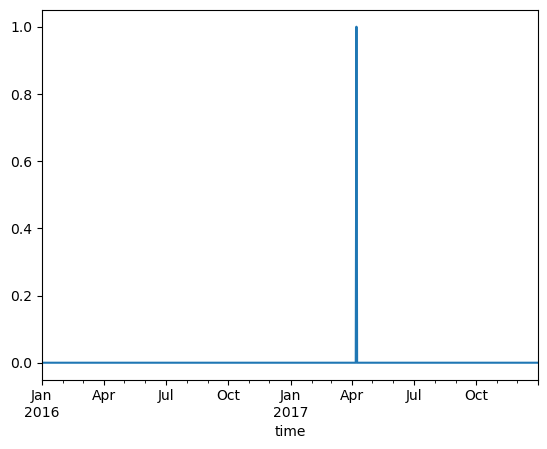

In [73]:
output = qaqc_unusual_gaps_precip(sub_df, 'pr', threshold=20, verbose=False)
output.astype("int").plot()

#Check what dates were flagged 
output[output]

In [74]:
sub_df_2 = sub_df.copy()
sub_df_2[var].iloc[[325,1000]] = 500

/var/folders/dj/qqhqnt2n4993vwmy6qcpnbk80000gn/T/ipykernel_18720/1053285579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_2[var].iloc[[325,1000]] = 500


time
2016-01-13    True
2016-02-05    True
2017-04-08    True
Name: pr, dtype: bool

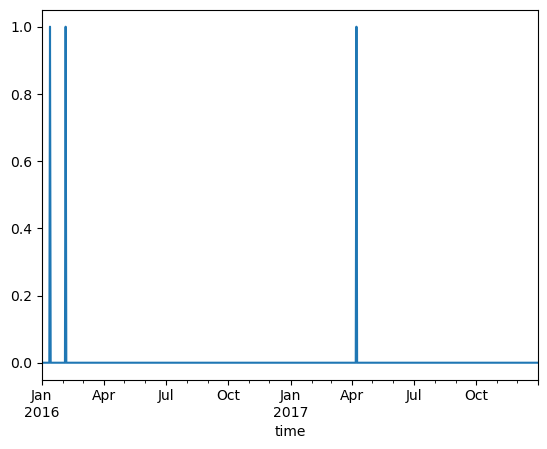

In [75]:
output = qaqc_unusual_gaps_precip(sub_df_2, 'pr', threshold=20, verbose=False)
output.astype("int").plot()

#Check what dates were flagged 
output[output]

### "Looping over months" version of `qaqc_unusual_gaps_precip`

<div style="width: 70%;">
  This function uses the same `check_differences` function, but loops over months in case
    this is neccesary for clarity or other things
</div>

In [77]:
def qaqc_unusual_gaps_precip(df, var, threshold=200, verbose=False):
    ### Filter df to precipitation variables and sum daily observations

    logger.info("Running qaqc_unusual_gaps_precip on: {}".format(var))
    new_df = df.copy()
    df_valid = grab_valid_obs(new_df, var)

    # aggregate to daily, subset on time, var, and eraqc var
    df_sub = df_valid[["time", 'year','month', 'day', var, var+"_eraqc"]]
    df_dy = df_sub.resample("1D", on="time").agg({var: "sum",var+"_eraqc": "first", "year": "first", "month": "first", "day": "first"})#.reset_index()

    ### Create a pd.Series with all False with the same length and index than the input df_dy
    output = pd.Series(len(df_dy[var])*[False], index=df_dy.index)
    
    # compare all precipitation obs in a single month, all years
    for mon in range(1, 13):
        month_flags = []
        # Select month data
        monthly_df = df_dy.loc[df_dy.month == mon]

        monthly_output = monthly_df[var].transform(check_differences, threshold=threshold)
        output.loc[monthly_output.index] = monthly_output.values
    
    ### VANESA, I don't know how you're flagging here. For now, I will return a flag column 
    ### with True or False
    ### variable output is True for flag values, False for non-flagged values
    
    return output

time
2016-01-13    True
2016-02-05    True
2017-04-08    True
dtype: bool

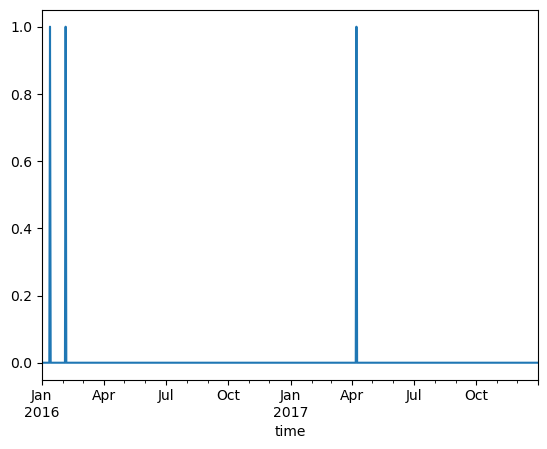

In [78]:
output = qaqc_unusual_gaps_precip(sub_df_2, 'pr', threshold=20, verbose=False)
output.astype("int").plot()

#Check what dates were flagged 
output[output]